# Sistema de Recomendação

Este notebook apresenta algumas implementações de sistema de recomendação utilizando
o dataset Movielens.
Este notebook contém:
- Modelo de Sistema de Recomendação utilizando atributos latentes e produto interno
- Modelo utilizando atributos latentes concatenados e uma rede neural
- Calcula a predição para todos os filmes e usuários que não fizeram suas avaliações
- Visualiza a matriz de avaliações por usuários x filmes com todas as predições
- Análise do significado dos embeddings

Obs: Este notebook foi inspirado em exemplo divulgado pelo no [fast.ai](http://fast.ai)

## Importação da bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, Embedding
from keras.models import Model
from keras.regularizers import l2
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam

np.set_printoptions(formatter={'float': '{: 0.1f}'.format})


Using TensorFlow backend.


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


### Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset.ipynb) que é responsável por ler o dataset original e
prepará-lo para este notebook

Este dataset consiste de:
- 100.004 avaliações de filmes (amostras), feitas por
- 671 usuários, sobre
- 9066 filmes

As amostras estão no array `ratings` organizados da seguinte forma:
- cada linha é uma amostra
- coluna 0 é o iD do usuário
- coluna 1 é o iD do filme
- coluna 2 é a avaliação do usuários entre 0.0 e 5.0

In [2]:
data = np.load('../data/movielens_norm.npz')
ratings = data['ratings']
movie_names = data['movie_names']
n_samples = ratings.shape[0]
print('n_samples:',n_samples)
print('ratings:\n', ratings[:5])

n_samples: 100004
ratings:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


In [3]:
for i in (ratings[:5,1]).astype(np.int):
    print(movie_names[i])

Dangerous Minds (1995)
Dumbo (1941)
Sleepers (1996)
Escape from New York (1981)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [4]:
h_userId = np.bincount(ratings[:,0].astype(np.int))
n_users = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies = h_movieId.size
print('n_users:',n_users)
print('n_movies:',n_movies)

n_users: 671
n_movies: 9066


## Divisão dos dados em treinamento e validação

In [5]:
np.random.seed = 42

Faz a divisão com 80% das amostras para treinamento e 20% para validação:

In [6]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 79804  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]
valid: 20200  amostras:
 [[ 0.0  1017.0  2.0]
 [ 0.0  1087.0  2.0]
 [ 0.0  1708.0  3.0]
 [ 0.0  2380.0  1.0]
 [ 1.0  37.0  5.0]]


In [7]:
train_userId =  train[:,0]
train_movieId = train[:,1]
train_ratings = train[:,2]
valid_userId =  valid[:,0]
valid_movieId = valid[:,1]
valid_ratings = valid[:,2]

n_factors = 50

## Primeira solução - usando produto interno: Dot

<img src='../figures/Recomendacao_dot.png', width=600ptx></img>

O primeiro modelo é o produto interno entre os atributos latentes dos usuários e dos filmes.
Este produto interno é implementado pela operação `dot` do Keras. Como o modelo agora não é
sequencial, há necessidade de utilizarmos o modelo API:

In [8]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, 
              input_length=1, 
              embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, 
              input_length=1, 
              embeddings_regularizer=l2(1e-4))(movie_in)
x = keras.layers.dot([u, m],axes=-1)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [9]:
model.compile(Adam(0.001), loss='mse')
model.fit([train_userId, train_movieId], train_ratings, 
          batch_size=64, epochs=1, 
          validation_data=([valid_userId, valid_movieId], valid_ratings))

Train on 79804 samples, validate on 20200 samples
Epoch 1/1
79804/79804 [==============================] - 34s - loss: 10.0007 - val_loss: 4.3372

Os bons modelos [best benchmarks](http://www.librec.net/example.html) são próximos de 0.9, há necessidade de melhorias.

### Predição de usuário e filme

Para calcular qualquer predição de qualquer usuário e qualquer filme, usa-se o `predict` do modelo treinado:

In [11]:
model.predict([np.array([3]), np.array([6])])

array([[ 2.7]], dtype=float32)

##  Usado Rede Neural

<img src='../figures/Recomendacao_NN.png', width=600ptx></img>

Uma solução usando rede neural é concatenar a saída dos embeddings e em seguida colocar uma camada densa
antes da última camada de um neurônio. No exemplo a seguir foi utilizado uma camada de 70 neurônios.

In [12]:
user_in = Input(shape=(1,),dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, 
              embeddings_regularizer=l2(1e-4))(user_in)

movie_in = Input(shape=(1,),dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, 
              embeddings_regularizer=l2(1e-4))(movie_in)

In [13]:
x = keras.layers.concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
model_nn = Model([user_in, movie_in], x)
print(model_nn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [14]:
model_nn.compile(Adam(0.001), loss='mse')
model_nn.fit([train_userId, train_movieId], train_ratings, batch_size=64, epochs=1, # was 8 
          validation_data=([valid_userId, valid_movieId], valid_ratings))

Train on 79897 samples, validate on 20107 samples
Epoch 1/1
79897/79897 [==============================] - 24s - loss: 2.4434 - val_loss: 0.8986

Com esta rede, a perda já é bem melhor, comparável com os melhores sistemas de recomendação.

## Matriz de recomendações, por usuário e por filme

O sistema de recomendação pode ser visualizado por uma matriz onde as linhas sejam os
IDs dos usuários e as colunas sejam os IDs dos títulos dos filmes. Colocamos como -1
os elementos em que não existem avaliações. Esta matriz é bastante esparsa, pois existem
normalmente poucas avaliações feitas.

In [15]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


### Visualização da matriz de recomendações, original

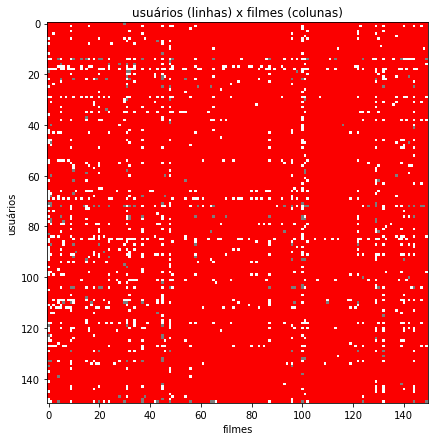

In [16]:
show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings == -1., 5, grid_ratings)
show_ratings[:,:,1] = np.where(grid_ratings == -1., 0., grid_ratings)
show_ratings[:,:,2] = np.where(grid_ratings == -1., 0., grid_ratings)


import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(show_ratings[:150,:150,:])
plt.xlabel('filmes')
plt.ylabel('usuários')
plt.show()

## Predições para todos os usuários e filmes

In [17]:
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
recommend = model_nn.predict([n2p_user, n2p_movie])

### Montagem da matriz de recomendação "cheia"

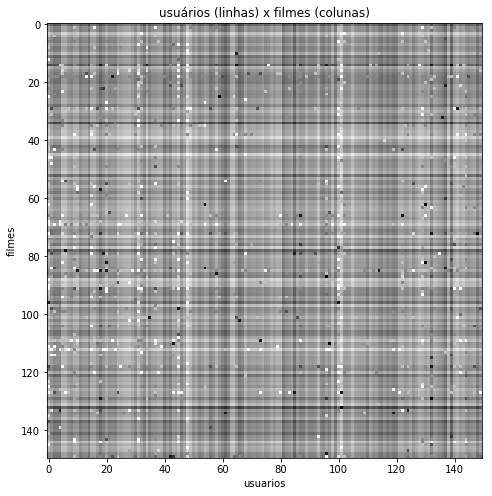

In [18]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0]

plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.xlabel('usuarios')
plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

### Visualização de uma parte da matriz

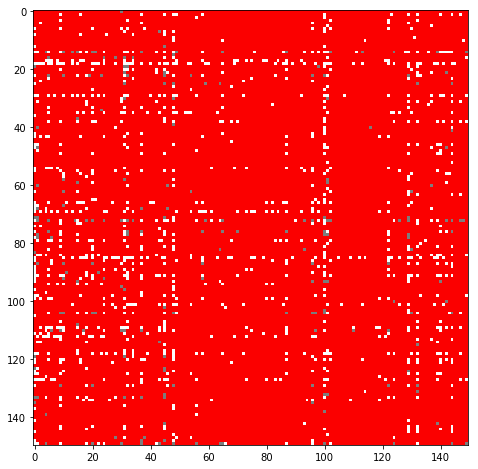

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(show_ratings[:150,:150,:])

### Visualização da parte de usuários mais ativos e filmes mais populares

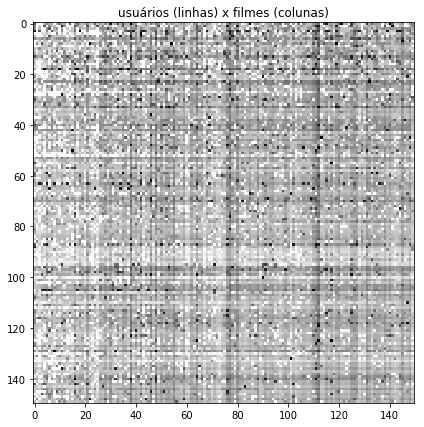

In [20]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

### Visualização dos usuários menos ativos e filmes menos avaliados

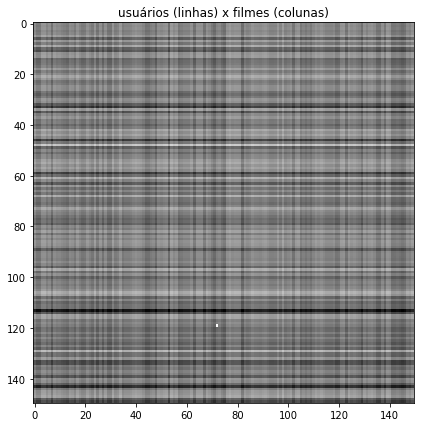

In [21]:
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[-150:,-150:],cmap='gray')
plt.show()

## Analise dos embeddings dos filmes

A análise a seguir será feita apenas com os 2000 filmes mais populares:

In [22]:
topMovies = io_popular_movies[:2000]

### Extração dos atributos latentes (embeddings) dos 2000 fimes mais populares

Para obter os atributos latentes dos 2000 filmes mais populares, primeiro criamos uma
nova rede, denominada `get_movie_emb`, a partir da rede `Model`, com a entrada apenas o ID dos filmes e
a saída `m`, após o embedding. Aplicamos a predição desta rede nos `topMovies`:

In [23]:
get_movie_emb = Model(movie_in, m)
m_emb = get_movie_emb.predict([topMovies])
movie_emb = np.squeeze(m_emb) # elimina dimensões 1
print(m_emb.shape)
movie_emb.shape

(2000, 1, 50)


(2000, 50)

Como o embedding de cada filme tem dimensão 50, é muito difícil conseguir analisá-lo desta forma.
Uma forma muito usual é reduzir esta dimensionalidade utilizando uma técnica denominada PCA -
Principal Component Analysis: [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/).
Iremos reduzir a dimensão dos embeddings de 50 para 3. 

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

#### Filmes com alto valor na primeira dimensão do PCA

In [25]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

0.0681859469858 Wings of the Dove, The (1997)
0.0565664710106 Antz (1998)
0.0459270135472 Children of the Revolution (1996)
0.0436067964231 Striking Distance (1993)
0.0425585803923 Princess Bride, The (1987)
0.040175784808 Star Trek II: The Wrath of Khan (1982)
0.0396624412539 Welcome to Sarajevo (1997)
0.039426122148 Mulan (1998)
0.0388560119511 Third Man, The (1949)
0.0385033665722 Godzilla (Gojira) (1954)
0.0380307952162 Down by Law (1986)
0.0373491581847 Bullets Over Broadway (1994)
0.0371153559446 187 (One Eight Seven) (1997)
0.0362573962389 Elizabeth (1998)
0.0360106420484 Picture Bride (Bijo photo) (1994)


#### Filmes com baixo valor na primeira dimensão do PCA

In [26]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

-0.0526569830174 Kicking and Screaming (1995)
-0.0527127472452 He Got Game (1998)
-0.0527416616308 Two if by Sea (1996)
-0.054620751268 Cobb (1994)
-0.0548507785219 Walking Dead, The (1995)
-0.0557706444428 Sudden Death (1995)
-0.0562694542336 Powder (1995)
-0.0568191463818 Grumpier Old Men (1995)
-0.0572129947191 Juror, The (1996)
-0.0573186447216 Goofy Movie, A (1995)
-0.0577386962501 Flintstones, The (1994)
-0.0581893982685 Taxi Driver (1976)
-0.0589160960045 Clerks (1994)
-0.059227774181 Madness of King George, The (1994)
-0.0636716558233 Othello (1995)


### Análise da segunda dimensão do PCA

In [27]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

#### Mais bem avaliados na segunda dimensão

In [28]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

0.0786847815896 Addiction, The (1995)
0.075013093141 Stupids, The (1996)
0.0661283199152 Hate (Haine, La) (1995)
0.0659910150187 Rapture, The (1991)
0.0652210423994 Friday the 13th Part VII: The New Blood (1988)
0.0648016112572 In the Company of Men (1997)
0.0641585072365 Glimmer Man, The (1996)
0.0624139087581 Stripes (1981)
0.0616010325359 Kalifornia (1993)
0.0611131662743 Escape to Witch Mountain (1975)
0.0607470091942 Airheads (1994)
0.0582364352251 Daylight (1996)
0.0573409110558 Some Kind of Wonderful (1987)
0.05625566564 Mrs. Winterbourne (1996)
0.0561307345306 Browning Version, The (1994)


#### Piores avaliados na segunda dimensão

In [29]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

-0.0552964215245 Beverly Hillbillies, The (1993)
-0.0553445749465 Rebel Without a Cause (1955)
-0.0571882999243 Soldier (1998)
-0.0591250113632 Message to Love: The Isle of Wight Festival (1996)
-0.0599554004068 Sound of Music, The (1965)
-0.0601043576684 Some Like It Hot (1959)
-0.0639288974797 Withnail & I (1987)
-0.0648248662964 Gold Diggers: The Secret of Bear Mountain (1995)
-0.0654775069326 Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1997)
-0.0676230829279 Pagemaster, The (1994)
-0.068501581882 Colonel Chabert, Le (1994)
-0.0694671126499 Basquiat (1996)
-0.0716819831853 National Lampoon's Senior Trip (1995)
-0.0756641431826 Elizabeth (1998)
-0.0765902736377 Threesome (1994)


### Análise da terceira dimensão do PCA

In [30]:
fac2 = movie_pca[2]
isort = np.argsort(fac2)[::-1]

#### Mais bem avaliados na terceira dimensão do PCA

In [31]:
for ii in isort[:15]:
    print(fac2[ii],movie_names[ii])

0.0734432182912 Mystery Science Theater 3000: The Movie (1996)
0.0716981574023 Deconstructing Harry (1997)
0.0706112970324 Before Sunrise (1995)
0.0682374296723 Milk Money (1994)
0.0679110971014 Suture (1993)
0.0647773636257 Cliffhanger (1993)
0.0647174950366 Simple Plan, A (1998)
0.0625413570568 Out to Sea (1997)
0.0620483453657 Crow: City of Angels, The (1996)
0.0615666048341 Cosi (1996)
0.0593594429754 On Golden Pond (1981)
0.0588323411178 Fearless (1993)
0.0584721768098 Dead Man (1995)
0.0581986044696 Man Who Knew Too Much, The (1934)
0.0572666592643 From Dusk Till Dawn (1996)


#### Piores avaliados na terceira dimensão do PCA

In [32]:
for ii in isort[-15:]:
    print(fac2[ii],movie_names[ii])

-0.0535795931436 Mars Attacks! (1996)
-0.053607095446 Bad Boys (1995)
-0.0543428312738 Mother (1996)
-0.0553309277409 Priest (1994)
-0.0562492740125 Mad City (1997)
-0.0565899598925 The Glass Shield (1994)
-0.0586086471415 Candidate, The (1972)
-0.0595797068449 Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)
-0.0599734611654 Angels and Insects (1995)
-0.0632896273313 Lost Horizon (1937)
-0.0664635524018 Lost Weekend, The (1945)
-0.0697343606939 Kids (1995)
-0.0730505037116 Adventures of Priscilla, Queen of the Desert, The (1994)
-0.0733442450314 Fallen Angels (Duo luo tian shi) (1995)
-0.0849808641966 Hotel de Love (1996)


### Visualizando duas dimensões do PCA

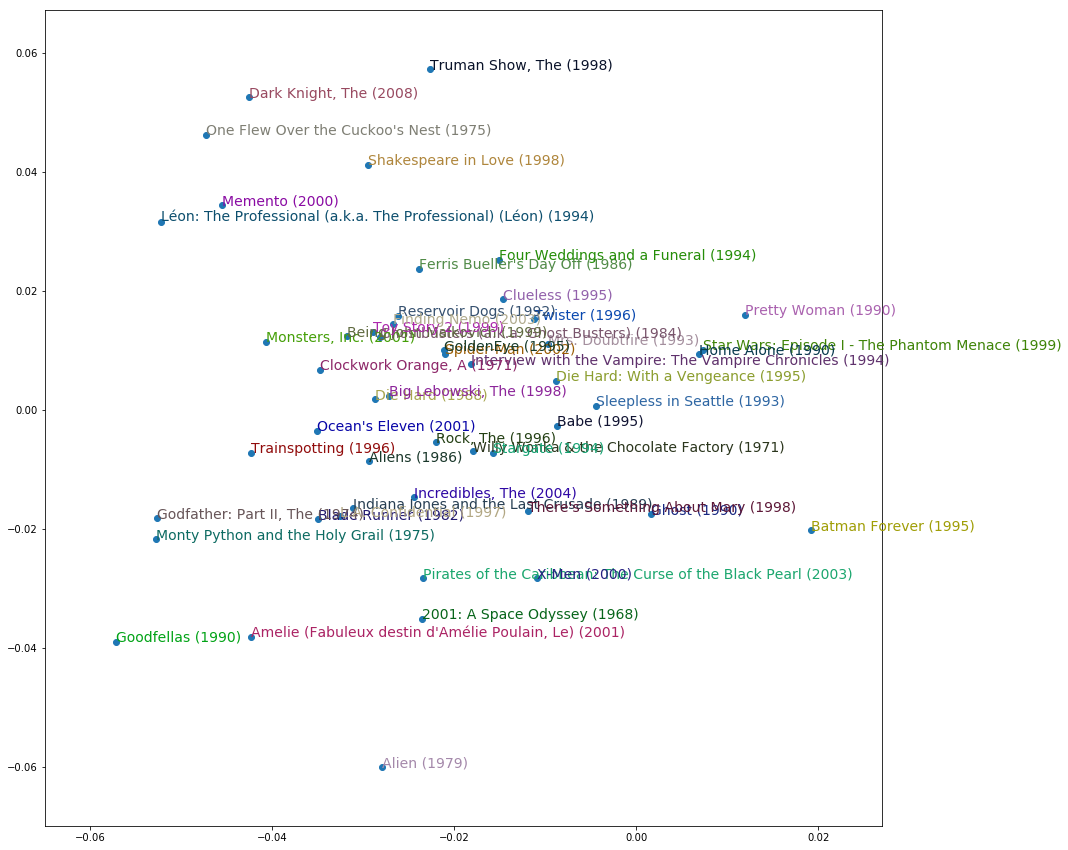

In [33]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercícios

1. Inclua um novo usuário, sem nenhuma avaliação. Treine a rede e verifique
   se após a rede treinada, se haverá alguma avaliação.
2. Com o novo usuário, faça uma única avaliação e verifique quais os 10 filmes
   mais recomendados para ele.

## Aprendizados com este notebook